In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import keras_squeezenet.
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import keras.utils as image

In [6]:
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from keras import layers
from keras.models import Model
from keras.optimizers import Adam

In [8]:
dataset_url = "../cropped"

import pathlib
data_dir = pathlib.Path(dataset_url)
data_dir

WindowsPath('../cropped')

In [9]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('../cropped/Abnormal-Heartbeat/HB(1).jpg'),
 WindowsPath('../cropped/Abnormal-Heartbeat/HB(10).jpg'),
 WindowsPath('../cropped/Abnormal-Heartbeat/HB(100).jpg'),
 WindowsPath('../cropped/Abnormal-Heartbeat/HB(101).jpg'),
 WindowsPath('../cropped/Abnormal-Heartbeat/HB(102).jpg')]

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

928


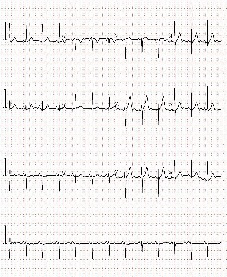

In [11]:
import PIL
PIL.Image.open(str(list(data_dir.glob('Normal/*'))[0]))

In [12]:
ecg_dict = {
    'normal': list(data_dir.glob('Normal/*')),
    'abnormal': list(data_dir.glob('Abnormal-Heartbeat/*')),
    'hist': list(data_dir.glob('History-Myocardial-Infarction/*')),
    'myco': list(data_dir.glob('Myocardial-Infarction/*')),
}

In [13]:
ecg_labels_dict = {
    'normal':0,
    'abnormal':1,
    'hist':2,
    'myco':3,
}

In [14]:
import cv2
img = cv2.imread(str(ecg_dict['normal'][0]))
img.shape

(277, 227, 3)

In [15]:
X, y = [], []

for label, images in ecg_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(227,227))
        X.append(resized_img)
        y.append(ecg_labels_dict[label])

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [19]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

<h1>Feature Extraction</h1>

In [20]:
base_model = SqueezeNet(include_top=False, weights='imagenet')

In [21]:
train_features = base_model.predict(X_train_scaled)
test_features = base_model.predict(X_test_scaled)

8/8 [==============================] - 3s 376ms/step


In [34]:
train_features.shape

(696, 13, 13, 512)

In [30]:
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

In [35]:
train_features_flat.shape

(696, 86528)

## SVM

In [36]:
import time
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [37]:
# Step 3: Use that output as input data for a new, smaller model (SVM)
clf = svm.SVC(kernel='linear', C=1.0)
start_time = time.time()

clf.fit(train_features_flat, np.argmax(y_train, axis=1))

training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 11.932483196258545 seconds


In [38]:
# Step 4: Make predictions on the test set
start_time = time.time()

predictions = clf.predict(test_features_flat)

testing_time = time.time() - start_time
print(f"Testing Time: {testing_time} seconds")

Testing Time: 3.9073591232299805 seconds


In [39]:
# Step 5: Evaluate the performance
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.9094827586206896
Precision: 0.9104219228882031
Recall: 0.9094827586206896
F1 Score: 0.9086334009551836


## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
start_time = time.time()
knn_classifier.fit(train_features_flat, np.argmax(y_train, axis=1))
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 0.23208260536193848 seconds


In [42]:
# Step 4: Make predictions on the test set
start_time = time.time()
predictions = knn_classifier.predict(test_features_flat)
testing_time = time.time() - start_time
print(f"Testing Time: {testing_time} seconds")

Testing Time: 5.960798263549805 seconds


In [43]:
# Step 5: Evaluate the performance
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.7413793103448276
Precision: 0.7673703568100121
Recall: 0.7413793103448276
F1 Score: 0.7302177003182844


## Decision Tree 

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
start_time = time.time()

decision_tree_classifier.fit(train_features_flat, np.argmax(y_train, axis=1))

training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 25.513919830322266 seconds


In [46]:
# Step 4: Make predictions on the test set
start_time = time.time()

predictions = decision_tree_classifier.predict(test_features_flat)

testing_time = time.time() - start_time
print(f"Testing Time: {testing_time} seconds")

Testing Time: 0.08256030082702637 seconds


In [47]:
# Step 5: Evaluate the performance
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.8836206896551724
Precision: 0.8868078355740443
Recall: 0.8836206896551724
F1 Score: 0.8779469246469203


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()

random_forest_classifier.fit(train_features_flat, np.argmax(y_train, axis=1))

training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 11.210459232330322 seconds


In [50]:
# Step 4: Make predictions on the test set
start_time = time.time()

predictions = random_forest_classifier.predict(test_features_flat)

testing_time = time.time() - start_time
print(f"Testing Time: {testing_time} seconds")

Testing Time: 0.23380613327026367 seconds


In [51]:
# Step 5: Evaluate the performance
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.9525862068965517
Precision: 0.9535057636222072
Recall: 0.9525862068965517
F1 Score: 0.9525376111122361


## Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB

In [53]:
naive_bayes_classifier = GaussianNB()
start_time = time.time()

naive_bayes_classifier.fit(train_features_flat, np.argmax(y_train, axis=1))


training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 1.9726417064666748 seconds


In [54]:
# Step 4: Make predictions on the test set
start_time = time.time()

predictions = naive_bayes_classifier.predict(test_features_flat)

testing_time = time.time() - start_time
print(f"Testing Time: {testing_time} seconds")

Testing Time: 3.495438575744629 seconds


In [55]:
# Step 5: Evaluate the performance
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.8793103448275862
Precision: 0.8802958395683376
Recall: 0.8793103448275862
F1 Score: 0.8783969708910405
